### Why a different statistical method may be needed in your A/B tests when measuring the relative change (bootstrapped confidence intervals).

#### Introduction

It is a common scenario in A/B testing in needing our variant to beat our control by a predetermined hurdle rate
in order for it to be economically viable. Furthermore, this hurdle rate may need to be quoted in relative terms. This is because
value is often tied to the relative (or proportional) movement in metrics.   

To give an example,
consider a scenario where we want to roll out a new website design. 
If rolled out to 100% of traffic, due to increased resources of maintaing the new website (labour, servers, etc), our costs will increase compared to using the old website. Therefore, any positive
change between the variant and control is not enough -  we need the variant to beat the control by a margin that offsets the
new ongoing costs. In addition, our estimate of the cost increase is relative to the costs of the old website - our costs will rise by x%
if we implement the new website to 100% of traffic. Therefore revenue per user (or whatever KPI is most meaningful) must rise by y% in relative terms to at least break even.  

This is whats known as a "Superiority" A/B test as labelled by Georgiev. The first  point about a "Superiority" test (i.e needing to clear a hurdle rate) is fairly straight-forward to integrate
into our hypothesis test. In the case where any positive change were required in our A/B test, we would set up our null hypothesis
to be $H_0: \mu=0$ for a two-sided test or $H_0: \mu \le 0$ for a one-sided test. With this condition, we are now
exclusively using a one-side hypothesis test: $H_0: \mu \le h$ where $h$ is the hurdle rate.

The second point about using the relative change (instead of absolute change) has a much bigger impact
on our A/B testing approach as we will soon see.

#### Relative change between sample means: Statistical Inference

For a given sample size, we have the following sampling distributions:                                                                                                

\begin{equation}
\bar{\Delta}_{rel} = \frac{\bar{Y} - \bar{X}}{\bar{X}}
\end{equation}

\begin{equation}
\bar{\Delta}_{abs} = \bar{Y} - \bar{X}
\end{equation}

where:

$\bar{X}$ is a random variable coming from the sampling distribution for the sample control mean  
$\bar{Y}$ is a random variable coming from the sampling distribution for the sample variant mean  
$\bar{\Delta}_{rel}$ is a random variable coming from the sampling distribution of the relative change in sample control mean and sample variant mean   
$\bar{\Delta}_{abs}$ is a random variable coming from the sampling distribution of the absolute change in sample control mean and sample variant mean   
Remember that $\bar{X}$,$\bar{Y}$,$\bar{\Delta}_{rel}$,$\bar{\Delta}_{abs}$ are all random variables as
they come from sampling distributions.


Based on the Central Limit Theorem, we know $\bar{X}$,$\bar{Y}$  will each converge to a normal distribution as the sample size gets
large. We also know that difference between two normal distributions is normal. So it stands that $\bar{\Delta}_{abs}$ ~ $N(\bar{y} - \bar{x},\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}$) as the sample size gets large. This is the reason we can use the the familiar 95% confidence interval formula for the absolute change in the means:

\begin{equation}
(\bar{y} - \bar{x}) \pm 1.96 \times \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}
\end{equation}

where:  
$\bar{y}$, $s_2^2$, $n_2$ are the sample mean, sample variance, sample size from the variant group respectively.  
$\bar{x}$, $s_1^2$, $n_1$ are the sample mean, sample variance, sample size from the control group respectively  



However, $\bar{\Delta}_{rel}$ doesn't follow a known distribution and we can't say how this sampling distribution will behave as
$n$ gets large (i.e we can't use the CLT). 
                
A common workaround to estimate the relative change is to calculate the confidence interval for the absolute change in the
means and then divide this by the sample mean of the control group to get a metric in "relative" units. Then we use the known relationship between
confidence intervals and hypothesis tests - if our confidence interval contains our hypothesised value then we can't reject null hypothesis.

For example, let's say we need the the variant to beat the control by 10% in relative terms in order
to be rolled out. Our sample control mean is 2% and sample variant mean 3%. Our 95% confidence interval for the absolute change is
[0.5%,1.5%]. Our 95% confidence interval for the "naive" relative change is then [0.5%/2%,1.5%/2%] = [25%,75%].

Mathematically, we can define the "naive" relative change as:  

\begin{equation}
\bar{\Delta}_{naive-rel} = \frac{\bar{Y} - \bar{X}}{\bar{x}}
\end{equation}

where:
$\bar{x}$  is the mean of the control sample we actually observe  

In other words, we calculate the sampling distribution for the absolute change and then scale it by a 
constant (the constant is the mean of the control sample we actually observe) to "approximate" the sampling distribution
for relative change.



#### Naive relative change vs True relative change

Is our naive sampling distribution likely to be similar to the true sampling distribution for relative change? We can turn to numerical methods to answer this question. 
Firstly, we can approximate the true sampling distribution for the relative change between the sample means with Bootstrapping. Bootstrapping is a resampling technique employed on the original sample which estimates the sampling distribution of a specified statistic. 
Bootstrapping will estimate the sampling distribution of any chosen test statistic on any population distribution (except for a few exceptions which are not applicable in this setup).

Secondly, we need to calculate both sampling distributions (naive transform and bootstrapped) a large number of times based on different random samples
to prove our estimates hold generally. We therefore use Monte Carlo simulation to estimate the median standard error and median mean for both sampling distributions. Note
that we specify the median rather than the average as we are likely to obtain some extreme values for our mean and standard error estimates from the bootstrapped sampling distributions due to the nature of the bootstrap procedure at relatively small sample sizes/low conversion rates.

1. Draw a random sample of size n from both the control and variant groups with predetermined means. Each observation is just a Bernouilli trial so will either
be 0 or 1 (the means are just the probability of success).
2. Estimate the sampling distribution for the relative change using a) Bootstrapping and  b) the naive transform. We use 1000 data points to represent each
     sampling distribution.
3. Record the standard error (standard deviation of the sampling distributions) and the sample median from both sampling distributions.
4. Repeat step 1-3 a large number of times (i.e simulation step)

In [44]:
#statistic for the bootstrap - true relative change in sample means
def statistic_rel(x, y):
    control_mean_if_zero=0.000000001
    if (np.mean(x)==0):
        return (np.mean(y)-np.mean(x))/control_mean_if_zero
    else:
        return (np.mean(y)-np.mean(x))/np.mean(x)

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bootstrap
import pandas as pd
import math

def mc_sim_binomial( cr_control, cr_variant, n,n_trials):
    #store the stats
    sd_bootstrap=[]
    sd_naive=[]
    mean_bootstrap=[]
    mean_naive=[]
    
    for sim in range(n_trials):
        control = np.random.binomial(1, cr_control, n)
        variant = np.random.binomial(1, cr_variant, n)

        #naive relative change sampling distribution approximation using absolute change
        clt_sampling_dist_abs_change=np.random.normal(
                                                    loc=variant.mean()-control.mean(),
                                                    scale=math.sqrt((np.var(control)/n)+(np.var(variant)/n)),
                                                    size=1000)/np.mean(control)

        #true relative change sampling distribution using bootstrapping
        data=(control,variant)
        b_strap_rel=bootstrap(data, statistic_rel, n_resamples=1000,vectorized=False,)
        
        sd_error_naive=np.std(clt_sampling_dist_abs_change)
        sd_error_bootstrap=np.std(b_strap_rel.bootstrap_distribution)
        sd_bootstrap.append(sd_error_bootstrap)
        sd_naive.append(sd_error_naive)
    
        mean_est_naive=np.mean(clt_sampling_dist_abs_change)
        mean_est_bootstrap=np.mean(b_strap_rel.bootstrap_distribution)
        mean_bootstrap.append(mean_est_bootstrap)
        mean_naive.append(mean_est_naive)
        
    return (sd_bootstrap,sd_naive,mean_bootstrap,mean_naive)



Let's consider a scenario where the variant mean exceeds the control mean by 50% in relative terms.

In [46]:
res=mc_sim_binomial(cr_control = 0.03,
                    cr_variant = 0.045,
                    n=1000,
                    n_trials=500
                    )

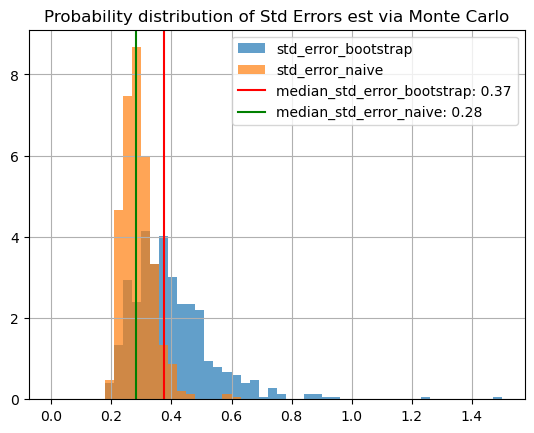

In [47]:
pd.Series(res[0]).hist(density=True,bins=50,alpha=0.7,range=(0,1.5),label='std_error_bootstrap')
pd.Series(res[1]).hist(density=True,bins=50,alpha=0.7,range=(0,1.5),label='std_error_naive')
plt.axvline(np.median(res[0]),label='median_std_error_bootstrap: '+str(round(np.median(res[0]),2)),color='red')
plt.axvline(np.median(res[1]),label='median_std_error_naive: '+str(round(np.median(res[1]),2)),color='green')
plt.title('Probability distribution of Std Errors est via Monte Carlo')

plt.legend()

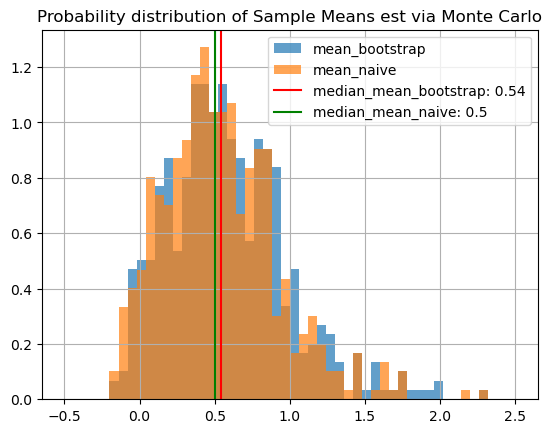

In [48]:
pd.Series(res[2]).hist(density=True,bins=50,alpha=0.7,range=(-0.5,2.5),label='mean_bootstrap')
pd.Series(res[3]).hist(density=True,bins=50,alpha=0.7,range=(-0.5,2.5),label='mean_naive')
plt.axvline(np.median(res[2]),label='median_mean_bootstrap: '+str(round(np.median(res[2]),2)),color='red')
plt.axvline(np.median(res[3]),label='median_mean_naive: '+str(round(np.median(res[3]),2)),color='green')
plt.title('Probability distribution of Sample Means est via Monte Carlo')

plt.legend()

We can see that the standard error from our naive
transform-estimated sampling distribution is lower than the standard error on our bootstrapped sampling distribution while the sample means are broadly aligned. In other words,
by using this naive transform, we are understating the true variation in our statistic leading to over-confidence in our estimate of the true effect. **The consequence of this is that we will end up rejecting the null hypothesis more often than our accepted significance level**.

Now consider a scenario where the variant mean falls below the control mean by 50% in relative terms.

In [49]:
res2=mc_sim_binomial(cr_control = 0.03,
                    cr_variant = 0.015,
                    n=1000,
                    n_trials=500
                    )

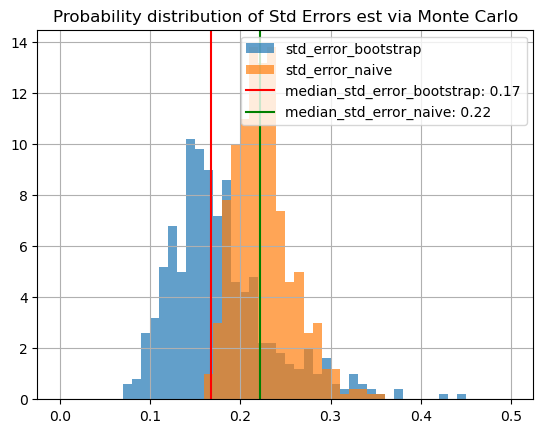

In [50]:
pd.Series(res2[0]).hist(density=True,bins=50,alpha=0.7,range=(0,0.5),label='std_error_bootstrap')
pd.Series(res2[1]).hist(density=True,bins=50,alpha=0.7,range=(0,0.5),label='std_error_naive')
plt.axvline(np.median(res2[0]),label='median_std_error_bootstrap: '+str(round(np.median(res2[0]),2)),color='red')
plt.axvline(np.median(res2[1]),label='median_std_error_naive: '+str(round(np.median(res2[1]),2)),color='green')
plt.title('Probability distribution of Std Errors est via Monte Carlo')

plt.legend()

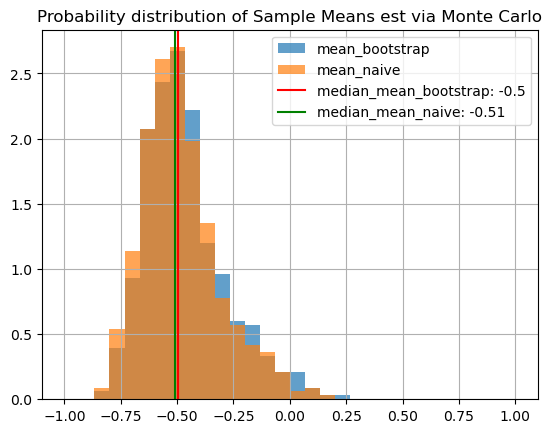

In [51]:
pd.Series(res2[2]).hist(density=True,bins=30,alpha=0.7,range=(-1,1),label='mean_bootstrap')
pd.Series(res2[3]).hist(density=True,bins=30,alpha=0.7,range=(-1,1),label='mean_naive')
plt.axvline(np.median(res2[2]),label='median_mean_bootstrap: '+str(round(np.median(res2[2]),2)),color='red')
plt.axvline(np.median(res2[3]),label='median_mean_naive: '+str(round(np.median(res2[3]),2)),color='green')
plt.title('Probability distribution of Sample Means est via Monte Carlo')

plt.legend()

Our results have flipped compared to the case where the true effect was positive: the standard error from our naive relative change estimate is now higher than the standard error from our bootstrapped sampling distribution.
The consequence of this scenario is that we have introduced extra unwarranted uncertainty into our estimate. **So we will end up failing to reject the null
hypothesis more often that we should in situations when there actually is an effect present (i.e reduced power)**

#### Type 1 error impact (Naive vs Bootstrap)

All of our conclusions so far have been on the assumption that we are measuring the true sampling distribution for relative change with our bootstrap
technique - now it's time to validate that claim! If our bootstrapped approximation really does capture the correct sampling distribution for the 
relative change then our empirical Type 1 error (which we can estimate via Monte Carlo) should be equal to the significance level we set before the test.

We can also adopt a similar approach for our naive approach to estimate the sampling distribution for relative change.
In the case of positive effect (variant mean > control mean), we should expect to see a higher empirical type 1 error rate
vs nominal type 1 error rate. We can set this up as follows:  
    
1. Set up our hypothesis test with significance $\alpha$ as being the following:  
$H_0: {\Delta}_{rel}$ is less than or equal to x%  
$H_A: {\Delta}_{rel}$ is greater x%  
2. Set the population means for the control and variant so that the population relative change is equal to x%. This is the
    largest number the population relative change can take and still satisfy the null hypothesis.
3. Draw a random sample of size n from both the control and variant groups with these pre-defined means.   
4. Estimate the sampling distribution for the relative change using bootstrapping and the naive transform. 
5. Construct the $(1-2\alpha)$ confidence interval for both sampling distributions. If the confidence interval clears the hurdle, then we can reject the one-sided null hypothesis at significance level $\alpha$ we laid out in step 1.
6. Repeat step 3-6 a large number of times and count the proportion of times we reject our null hypothesis. If specified correctly, it should be $\alpha$                                                 

In [1]:
def mc_sim_binomial_2(  cr_control, 
                        n,
                        n_trials,
                        trc,
                        alpha):
    
    trc_reject=0 #for bootstrap
    nrc_reject=0 #for naive
    cr_variant=cr_control*(1+trc)
    
    for sim in range(n_trials):
        control = np.random.binomial(1, cr_control, n)
        variant = np.random.binomial(1, cr_variant, n)

        #naive relative change sampling distribution approximation using absolute change
        clt_sampling_dist_abs_change=np.random.normal(
                                                    loc=variant.mean()-control.mean(),
                                                    scale=math.sqrt((np.var(control)/n)+(np.var(variant)/n)),
                                                    size=1000)/np.mean(control)
        ci_b_abs = np.percentile(clt_sampling_dist_abs_change,q=alpha*100),np.percentile(clt_sampling_dist_abs_change,q=100*(1-alpha))
        
        # check if confidence interval clears true value
        if ci_b_abs[0] > trc:
            brc_reject += 1
            
        # true relative change sampling distribution using bootstrapping
        data=(control,variant)
        b_strap_rel=bootstrap(data, statistic_rel, n_resamples=1000,vectorized=False,confidence_level=1-2*alpha)
        ci_b = b_strap_rel.confidence_interval
     
        # check if confidence interval clears true value
        if ci_b[0] > trc:
            trc_reject += 1
            

        
    return (trc_reject/n_trials,brc_reject/n_trials)

In [22]:
#all possible permutations
control_rates=[0.005,0.01,0.02,0.05]
trcs=[0.1,0.25,0.5,1,2] #true effects
ns=[500,1000,2000,5000] #sample sizes

#to store results
n_list=[]
trc_list=[]
control_list=[]
type_1_bootstrap=[]
type_1_naive=[]

for n in ns:
    for c in control_rates:
        for trc in trcs:
            res=mc_sim_binomial_2( cr_control=c, 
                    n=n,
                    n_trials=1000,
                    trc=trc,
                   alpha=0.05)
            n_list.append(n)
            trc_list.append(trc)
            control_list.append(c)
            type_1_bootstrap.append(res[0])
            type_1_naive.append(res[1])


/Users/conor.smith2/Library/Caches/pypoetry/virtualenvs/experimentation-MEJlJO1k-py3.8/lib/python3.8/site-packages/scipy/stats/_resampling.py:144: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/Users/conor.smith2/Library/Caches/pypoetry/virtualenvs/experimentation-MEJlJO1k-py3.8/lib/python3.8/site-packages/scipy/stats/_resampling.py:97: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))
/var/folders/1h/kwzt06j933380jnw8zglhhyr0000gp/T/ipykernel_39783/3681888929.py:15: RuntimeWarning: divide by zero encountered in divide
  clt_sampling_dist_abs_change=np.random.normal(
/Users/conor.smith2/Library/Caches/pypoetry/virtualenvs/experimentation-MEJlJO1k-py3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  di

500 0.005 0.1 0.044 0.02


/Users/conor.smith2/Library/Caches/pypoetry/virtualenvs/experimentation-MEJlJO1k-py3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4575: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/conor.smith2/Library/Caches/pypoetry/virtualenvs/experimentation-MEJlJO1k-py3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4576: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5)


500 0.005 0.25 0.065 0.026
500 0.005 0.5 0.066 0.034
500 0.005 1 0.079 0.056
500 0.005 2 0.071 0.11
500 0.01 0.1 0.015 0.046
500 0.01 0.25 0.027 0.064
500 0.01 0.5 0.021 0.1
500 0.01 1 0.018 0.113
500 0.01 2 0.031 0.176
500 0.02 0.1 0.027 0.052
500 0.02 0.25 0.033 0.083
500 0.02 0.5 0.043 0.099
500 0.02 1 0.035 0.129
500 0.02 2 0.052 0.157
500 0.05 0.1 0.04 0.054
500 0.05 0.25 0.052 0.079
500 0.05 0.5 0.049 0.103
500 0.05 1 0.045 0.112
500 0.05 2 0.044 0.167
1000 0.005 0.1 0.023 0.047
1000 0.005 0.25 0.025 0.073
1000 0.005 0.5 0.01 0.073
1000 0.005 1 0.017 0.109
1000 0.005 2 0.015 0.16
1000 0.01 0.1 0.03 0.059
1000 0.01 0.25 0.033 0.061
1000 0.01 0.5 0.03 0.1
1000 0.01 1 0.035 0.116
1000 0.01 2 0.035 0.166
1000 0.02 0.1 0.035 0.056
1000 0.02 0.25 0.029 0.059
1000 0.02 0.5 0.04 0.093
1000 0.02 1 0.032 0.111
1000 0.02 2 0.055 0.191
1000 0.05 0.1 0.058 0.072
1000 0.05 0.25 0.051 0.073
1000 0.05 0.5 0.071 0.116
1000 0.05 1 0.046 0.111
1000 0.05 2 0.052 0.186
2000 0.005 0.1 0.036 0.048
2000

In [23]:
res_final = pd.DataFrame({
    'sample_size': n_list,
    'population_relative_change': trc_list,
    'control_rate': control_list,
    'type_1_error_bootstrap': type_1_bootstrap,
    'type_1_error_naive': type_1_naive
})

In [1]:
import plotly.express as px
fig = px.scatter(res_final, x="sample_size", y=["type_1_error_bootstrap",'type_1_error_naive'],facet_row="control_rate", facet_col='population_relative_change')
fig.show()

ModuleNotFoundError: No module named 'plotly'

Some observations to make based on the results:  

1. Using the bootstrap to estimate the relative change appears to be robust when sample size times control rate is greater than 25.
Loosely speaking, once we have 25 or more conversions in our control group (and regardless of true effect and sample size), our nominal type 1 error
matches the empirical type 1 error from the bootstrap (within +/- 1.5% error)  
2. Our Type 1 error using the naive transform rises substantially when the true relative change rises. For example,
when the actual relative change is 200%, control rate is 5%, sample size is 1000 and our null hypothesis is that the relative change is less than 200%, we will mistakenly
conclude the effect is greater than 200% 18.6% of the time - much higher than the nominal 5% significance we thought we were accepting!  
3. The last point worth highlighting is that we are considering the largest effect possible that satisfies the null hypothesis. So we are estimating the max Type 1 error for a given null hypothesis. Using the same
example as in point 2, if our null hypothesis is that the relative change is less than 200% and the actual relative change had been 150%, then our practical Type 1 error
will be less than 18.6%.

#### Conclusion

So what we have proved with this analysis? It's twofold:  
1. We've shown that using bootstrapped confidence intervals for relative change hypotheses are relatively (pardon the pun) robust.  
2. Put forward reasons against the use of naive relative change to quantify relative change in A/B testing.  

Therefore, to run a "Superiority" A/B test:
1. Specify the null and alternative hypothesis (with accepted significance level $\alpha$) based on the relative change hurdle. If the variant needs to beat control by 5% in relative terms then then null hypothesis is that the relative change between control and variant is less than 5%, the alternative is that the relative change is greater than or equal to 5%.
2. Run the booststrap to estimate the sampling distribution of the relative change in the sample control mean and sample variant mean.
3. Construct the $(1-2\alpha)$ confidence interval for the relative change between the sample control mean and sample variant mean. If the confidence interval clears the hurdle, then we can reject the one-sided null hypothesis at significance level $\alpha$ we laid out in step 1
   